<a href="https://colab.research.google.com/github/GeorgeM2000/Automatic-Keyword-Extraction-from-Documents/blob/main/Automatic_Keyword_Extraction_from_Documents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
# Use in Google Colab
#!pip install inflection

In [ ]:
# Use in Google Colab
!python -m spacy download en_core_web_md

In [ ]:
# Use in Google Colab
#!pip install sentence-transformers

In [1]:
import nltk
import zipfile
import os
from collections import Counter, defaultdict
import re
from nltk.tokenize import RegexpTokenizer
import json
import string
from enum import Enum
from itertools import chain, groupby, product
from typing import Callable, DefaultDict, Dict, List, Optional, Set, Tuple
from sklearn.metrics import precision_recall_fscore_support
import math
from nltk.corpus import wordnet
import inflect
import spacy
from itertools import combinations
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from typing import Any
import matplotlib.pyplot as plt

In [3]:
# Use in Google Colab
"""
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
"""

# Use locally
nltk.download('punkt', download_dir='/home/georgematlis/AUTH/DWS/NLP/Automatic_Keyword_Extraction_from_Documents/Downloads')
nltk.download('stopwords', download_dir='/home/georgematlis/AUTH/DWS/NLP/Automatic_Keyword_Extraction_from_Documents/Downloads')
nltk.download('wordnet', download_dir='/home/georgematlis/AUTH/DWS/NLP/Automatic_Keyword_Extraction_from_Documents/Downloads')

[nltk_data] Downloading package punkt to /home/georgematlis/AUTH/DWS/N
[nltk_data]     LP/Automatic_Keyword_Extraction_from_Documents/Downloa
[nltk_data]     ds...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/georgematlis/AUTH/D
[nltk_data]     WS/NLP/Automatic_Keyword_Extraction_from_Documents/Dow
[nltk_data]     nloads...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/georgematlis/AUTH/DWS
[nltk_data]     /NLP/Automatic_Keyword_Extraction_from_Documents/Downl
[nltk_data]     oads...


True

In [2]:
nltk.data.path.append("/home/georgematlis/AUTH/DWS/NLP/Automatic_Keyword_Extraction_from_Documents/Downloads")

# Corpus - Corpus Preprocessing
In this section we load the corpus and examine the scientific abstracts and their corresponding keywords. We split the scientific abstracts and their keywords to a training set, a validation set, and a testing set. The training set will contain 1000 abstracts, the validation and testing set will contain 500 abstracts.

In [ ]:
!rm -rf Inspec/

In [3]:
# Path to the zip file you want to extract
zip_file_path = '/content/Inspec.zip'

# Directory where you want to extract the contents
extract_directory = '/content/'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_directory, exist_ok=True)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents to the specified directory
    zip_ref.extractall(extract_directory)

print("Zip file extraction complete.")

Zip file extraction complete.


In [3]:
# Directory path containing the documents
#abstracts_folder_path = '/content/Inspec/docsutf8/'
abstracts_folder_path = 'Inspec/docsutf8/'

In [4]:
document_names = []

# Loop through each file in the folder
for filename in os.listdir(abstracts_folder_path):
    file_path = os.path.join(abstracts_folder_path, filename)

    # Check if the file is a regular file (not a directory)
    if os.path.isfile(file_path):
        # Extract the name of the file without its extension
        file_name, file_extension = os.path.splitext(filename)

        try:

            # Convert the file name string to an integer
            file_name_as_int = int(file_name)
            document_names.append(file_name_as_int)

            """
            with open(file_path, 'r') as file:
                print(f"Contents of {file_name_as_int}:")
                print(file.read())
                print("------------------------------")
            """


        except ValueError:
            print(f"Filename {filename} does not represent an integer.")



#print("------------------------------")
sorted_document_names = sorted(document_names)
print(sorted_document_names)
print(document_names)

[2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 

In [4]:
# Directory path containing the documents
#keys_folder_path = '/content/Inspec/keys/'
keys_folder_path = 'Inspec/keys/'

In [6]:
document_keyword_names = []

# Loop through each file in the folder
for filename in os.listdir(keys_folder_path):
    file_path = os.path.join(keys_folder_path, filename)

    # Check if the file is a regular file (not a directory)
    if os.path.isfile(file_path):
        # Extract the name of the file without its extension
        file_name, file_extension = os.path.splitext(filename)

        try:
            # Convert the file name string to an integer
            file_name_as_int = int(file_name)
            document_keyword_names.append(file_name_as_int)

            """
            with open(file_path, 'r') as file:
                #print(f"Contents of {file_name_as_int}:")
                #print(file.read())
                #print("------------------------------")
            """

        except ValueError:
            print(f"Filename {filename} does not represent an integer.")


#print("------------------------------")
sorted_document_keyword_names = sorted(document_keyword_names)
print(sorted_document_keyword_names)
print(document_keyword_names)

[2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 

In [7]:
print(f'{len(sorted_document_names)} - {len(sorted_document_keyword_names)}')

2000 - 2000


In [8]:
for index in range(len(sorted_document_names)):
  if (sorted_document_names[index] == sorted_document_keyword_names[index]) == False:
    print(f'Misalignment in the abstract {sorted_document_names[index]} and its keywords {sorted_document_keyword_names[index]}')

In [9]:
# Function to sort and rename files based on their integer filenames
def sort_files(folder_path):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Sort the files based on their filename converted to integers
    files.sort(key=lambda x: int(os.path.splitext(x)[0]))

    # Rename the files in sequential order
    for index, filename in enumerate(files, start=1):
        current_file_path = os.path.join(folder_path, filename)
        file_name, file_extension = os.path.splitext(filename)

        # Pad the index with zeros to maintain the same length of filenames
        new_filename = f"{index}{file_extension}"

        new_file_path = os.path.join(folder_path, new_filename)

        os.rename(current_file_path, new_file_path)
        print(f"File '{filename}' moved to '{new_filename}'.")

In [10]:
sort_files(abstracts_folder_path)

File '2.txt' moved to '1.txt'.
File '3.txt' moved to '2.txt'.
File '4.txt' moved to '3.txt'.
File '6.txt' moved to '4.txt'.
File '7.txt' moved to '5.txt'.
File '8.txt' moved to '6.txt'.
File '9.txt' moved to '7.txt'.
File '11.txt' moved to '8.txt'.
File '12.txt' moved to '9.txt'.
File '13.txt' moved to '10.txt'.
File '14.txt' moved to '11.txt'.
File '15.txt' moved to '12.txt'.
File '16.txt' moved to '13.txt'.
File '17.txt' moved to '14.txt'.
File '18.txt' moved to '15.txt'.
File '19.txt' moved to '16.txt'.
File '20.txt' moved to '17.txt'.
File '21.txt' moved to '18.txt'.
File '22.txt' moved to '19.txt'.
File '23.txt' moved to '20.txt'.
File '24.txt' moved to '21.txt'.
File '25.txt' moved to '22.txt'.
File '26.txt' moved to '23.txt'.
File '27.txt' moved to '24.txt'.
File '28.txt' moved to '25.txt'.
File '29.txt' moved to '26.txt'.
File '30.txt' moved to '27.txt'.
File '31.txt' moved to '28.txt'.
File '32.txt' moved to '29.txt'.
File '33.txt' moved to '30.txt'.
File '34.txt' moved to '31

In [11]:
sort_files(keys_folder_path)

File '2.key' moved to '1.key'.
File '3.key' moved to '2.key'.
File '4.key' moved to '3.key'.
File '6.key' moved to '4.key'.
File '7.key' moved to '5.key'.
File '8.key' moved to '6.key'.
File '9.key' moved to '7.key'.
File '11.key' moved to '8.key'.
File '12.key' moved to '9.key'.
File '13.key' moved to '10.key'.
File '14.key' moved to '11.key'.
File '15.key' moved to '12.key'.
File '16.key' moved to '13.key'.
File '17.key' moved to '14.key'.
File '18.key' moved to '15.key'.
File '19.key' moved to '16.key'.
File '20.key' moved to '17.key'.
File '21.key' moved to '18.key'.
File '22.key' moved to '19.key'.
File '23.key' moved to '20.key'.
File '24.key' moved to '21.key'.
File '25.key' moved to '22.key'.
File '26.key' moved to '23.key'.
File '27.key' moved to '24.key'.
File '28.key' moved to '25.key'.
File '29.key' moved to '26.key'.
File '30.key' moved to '27.key'.
File '31.key' moved to '28.key'.
File '32.key' moved to '29.key'.
File '33.key' moved to '30.key'.
File '34.key' moved to '31

In [5]:
training_set = {}
validation_set = {}
testing_set = {}

In [6]:
# Training set creation
for filename in range(1, 1001):
  abstract_file_name = f"{filename}.txt"
  keys_file_name = f"{filename}.key"
  abstract_file_path = os.path.join(abstracts_folder_path, abstract_file_name)
  keys_file_path = os.path.join(keys_folder_path, keys_file_name)

  if os.path.exists(abstract_file_path) and os.path.exists(keys_file_path):
    training_set[abstract_file_name] = keys_file_name
  else:
    print(f'{filename} is missing.')

In [ ]:
# Validation set creation (Optional)
for filename in range(1001, 1501):
  abstract_file_name = f"{filename}.txt"
  keys_file_name = f"{filename}.key"
  abstract_file_path = os.path.join(abstracts_folder_path, abstract_file_name)
  keys_file_path = os.path.join(keys_folder_path, keys_file_name)

  if os.path.exists(abstract_file_path) and os.path.exists(keys_file_path):
    validation_set[abstract_file_name] = keys_file_name
  else:
    print(f'{filename} is missing.')

# Stoplist Generation
In this section we will generate stop words to use with the automatic keyword extraction algorithms.

In [14]:
!cp -r Inspec Inspec_StopWords

In [ ]:
!rm -rf Inspec_StopWords

In [7]:
# Initialize counters
term_frequency = Counter()  # Term frequency
document_frequency = Counter()  # Document frequency
keyword_frequency = Counter()  # Keyword frequency
adjacent_frequency = {}  # Adjacency frequency

In [8]:
#stopwords_abstracts_folder = '/content/Inspec_StopWords/docsutf8/'
#stopwords_keys_folder = '/content/Inspec_StopWords/keys/'

stopwords_abstracts_folder = 'Inspec_StopWords/docsutf8/'
stopwords_keys_folder = 'Inspec_StopWords/keys/'

In [9]:
abstracts_text = []
abstracts_keywords = []

In [18]:
for abstract, keys in training_set.items():

  with open(os.path.join(stopwords_abstracts_folder, abstract), 'r') as file:
    abstract_text = re.sub(r'(\n)([A-Z])', r'.\1\2', file.read())
    abstract_text = abstract_text.lower()
    abstract_text = ' '.join(abstract_text.split())
    abstracts_text.append(abstract_text)

  with open(os.path.join(stopwords_abstracts_folder, abstract), 'w') as file:
    file.write(abstract_text)


  new_keywords = []

  with open(os.path.join(stopwords_keys_folder, keys), 'r') as file:
    for line in file:
      cleaned_line = ' '.join(line.split())
      cleaned_line = cleaned_line.lower()
      new_keywords.append(cleaned_line)

  abstracts_keywords.append(new_keywords)

  with open(os.path.join(stopwords_keys_folder, keys), 'w') as file:
    for keyword in new_keywords:
      file.write(keyword + '\n')

In [10]:
# Use this if you have already created the "Inspec_StopWords" directory

for abstract, keys in training_set.items():
    with open(os.path.join(stopwords_abstracts_folder, abstract), 'r') as file:
        abstract_text = file.read()
        abstracts_text.append(abstract_text)

    new_keywords = []
    with open(os.path.join(stopwords_keys_folder, keys), 'r') as file:
        for line in file:
            new_keywords.append(line)

    abstracts_keywords.append(new_keywords)

In [11]:
# Function to process text and return word frequency
def process_text(text):
    words = re.findall(r'\b[\w-]+\b', text) #\w+
    return Counter(words)

In [12]:
# Process keywords to a set for faster lookup
keyword_term_frequency = Counter()

for keyword_file in range(1,1001):
  with open(os.path.join(stopwords_keys_folder, str(keyword_file) + '.key'), 'r', encoding='utf-8') as file:
    keywords = RegexpTokenizer(r'\b[\w-]+\b').tokenize(file.read())
    keyword_term_frequency.update(keywords)

In [13]:
# Process abstracts and calculate frequencies
for abstract, keys in training_set.items():
  with open(os.path.join(stopwords_abstracts_folder, abstract), 'r', encoding='utf-8') as file:
    abstract_text = file.read()

    tokens = RegexpTokenizer(r'\b[\w-]+\b').tokenize(abstract_text)
    distinct_words = set(tokens)

    # Calculate term frequency and document frequency
    term_frequency.update(process_text(abstract_text))
    document_frequency.update(distinct_words)


    for word in distinct_words:
      if word in keyword_term_frequency:
        # Place the corresponding keywords in a list
        keyword_frequency[word] = keyword_term_frequency[word]


In [ ]:
for word in term_frequency:

  abstract_keyword_index = -1
  for abstract in abstracts_text:

    abstract_keyword_index += 1
    for line in abstracts_keywords[abstract_keyword_index]:
      if word in adjacent_frequency:
        adjacent_frequency[word] += abstract.count(word + " " + line) + abstract.count(line + " " + word)
        #adjacent_frequency[word] += abstract.count(line + " " + word)
      else:
        adjacent_frequency[word] = abstract.count(word + " " + line) + abstract.count(line + " " + word)
        #adjacent_frequency[word] = abstract.count(line + " " + word)


In [14]:
# Read from the JSON file
with open('Adjacent_Frequency.json', 'r') as json_file:
    adjacent_frequency = json.load(json_file)

In [ ]:
# Write to a JSON file
with open('Adjacent_Frequency_T1500.json', 'w') as json_file:
    json.dump(adjacent_frequency, json_file)

In [15]:
print(f'Term Frequency:{term_frequency}')
print()

print(f'Document Frequency:{document_frequency}')
print()

print(f'Keyword Frequency:{keyword_frequency}')
print()

Term Frequency:Counter({'the': 8602, 'of': 5508, 'and': 3686, 'a': 3554, 'to': 2896, 'in': 2532, 'is': 2014, 'for': 1889, 'with': 1161, 'that': 1108, 'are': 1040, 'this': 971, 'on': 912, 'an': 812, 'we': 781, 'by': 748, 'as': 690, 'be': 590, 'system': 526, 'it': 499, 'from': 469, 'control': 452, 'using': 445, 'can': 438, 'which': 402, 'model': 392, 'paper': 374, 'systems': 370, 'method': 344, 'or': 322, 'new': 321, 'at': 321, 'data': 318, 's': 312, 'based': 294, 'information': 290, 'algorithm': 286, 'has': 284, 'used': 284, 'results': 279, 'have': 272, 'was': 245, 'two': 244, 'these': 244, 'time': 241, 'design': 238, 'also': 236, 'such': 231, 'not': 222, 'approach': 220, 'proposed': 216, 'problem': 214, 'its': 207, 'analysis': 203, 'use': 203, 'their': 197, 'between': 197, 'more': 195, 'one': 194, 'performance': 190, 'been': 184, 'our': 177, 'show': 177, 'models': 169, 'process': 163, 'study': 162, 'computer': 161, 'into': 161, 'when': 160, 'but': 159, 'methods': 158, '1': 158, 'some':

In [16]:
stoplists = [
    [],
    [],
    [],
    [],
    [],
    []
]

In [17]:
for word, freq in term_frequency.most_common():
  if document_frequency[word] > 10:
    stoplists[0].append(word)
    if adjacent_frequency[word] > keyword_frequency[word]:
      stoplists[3].append(word)
  if document_frequency[word] > 25:
    stoplists[1].append(word)
    if adjacent_frequency[word] > keyword_frequency[word]:
      stoplists[4].append(word)
  if document_frequency[word] > 50:
    stoplists[2].append(word)
    if adjacent_frequency[word] > keyword_frequency[word]:
      stoplists[5].append(word)
  #print(f'{word}:{freq} - {document_frequency[word]} - {keyword_frequency[word]} - {adjacent_frequency[word]}')

In [18]:
for stoplist in stoplists:
  print(len(stoplist))

1294
501
193
486
233
122


# RAKE (Rapid Automatic Keyword Extraction)

## RAKE Implementation from https://csurfer.github.io/rake-nltk/_build/html/_modules/rake_nltk/rake.html

In [19]:
# Readability type definitions.
Word = str
Sentence = str
Phrase = Tuple[str, ...]

In [20]:
class Metric(Enum):
    """Different metrics that can be used for ranking."""

    DEGREE_TO_FREQUENCY_RATIO = 0  # Uses d(w)/f(w) as the metric
    WORD_DEGREE = 1  # Uses d(w) alone as the metric
    WORD_FREQUENCY = 2  # Uses f(w) alone as the metric

In [37]:
class Rake:
    """Rapid Automatic Keyword Extraction Algorithm."""

    def __init__(
        self,
        stopwords: Optional[Set[str]] = None,
        punctuations: Optional[Set[str]] = None,
        language: str = 'english',
        ranking_metric: Metric = Metric.DEGREE_TO_FREQUENCY_RATIO,
        max_length: int = 100000,
        min_length: int = 1,
        include_repeated_phrases: bool = True,
        sentence_tokenizer: Optional[Callable[[str], List[str]]] = None,
        word_tokenizer: Optional[Callable[[str], List[str]]] = None,
        similarity_model: Any = None,
        keyword_threshold: float = 0.7,
        keyBERT_keywords: List[tuple] = None
    ):
        """Constructor.

        :param stopwords: Words to be ignored for keyword extraction.
        :param punctuations: Punctuations to be ignored for keyword extraction.
        :param language: Language to be used for stopwords.
        :param max_length: Maximum limit on the number of words in a phrase
                           (Inclusive. Defaults to 100000)
        :param min_length: Minimum limit on the number of words in a phrase
                           (Inclusive. Defaults to 1)
        :param include_repeated_phrases: If phrases repeat in phrase list consider
                            them as is without dropping any phrases for future
                            calculations. (Defaults to True) Ex: "Magic systems is
                            a company. Magic systems was founded by Raul".

                            If repeated phrases are allowed phrase list would be
                            [
                                (magic, systems), (company,), (magic, systems),
                                (founded,), (raul,)
                            ]

                            If they aren't allowed phrase list would be
                            [
                                (magic, systems), (company,),
                                (founded,), (raul,)
                            ]
        :param sentence_tokenizer: Tokenizer used to tokenize the text string into sentences.
        :param word_tokenizer: Tokenizer used to tokenize the sentence string into words.
        """
        # The similarity model. Could be any model with pre-trained embeddings. e.g Word2Vec, Spacy
        self.similarity_model = similarity_model
        
        # The similarity threshold between two individual words
        self.keyword_threshold: float = keyword_threshold

        # The keyBERT keywords that may be used to add supplementary keywords that RAKE hasn't computed
        if keyBERT_keywords:
            self.keyBERT_keywords = set(tuple(word.split()) for word in [item[0] for item in keyBERT_keywords])
        else:
           self.keyBERT_keywords = None

        # By default use degree to frequency ratio as the metric.
        if isinstance(ranking_metric, Metric):
            self.metric = ranking_metric
        else:
            self.metric = Metric.DEGREE_TO_FREQUENCY_RATIO

        # If stopwords not provided we use language stopwords by default.
        self.stopwords: Set[str]
        if stopwords:
            self.stopwords = stopwords
        else:
            self.stopwords = set(nltk.corpus.stopwords.words(language))

        # If punctuations are not provided we ignore all punctuation symbols.
        self.punctuations: Set[str]
        if punctuations:
            self.punctuations = punctuations
        else:
            self.punctuations = set(string.punctuation)

        # All things which act as sentence breaks during keyword extraction.
        self.to_ignore: Set[str] = set(chain(self.stopwords, self.punctuations))

        # Assign min or max length to the attributes
        self.min_length: int = min_length
        self.max_length: int = max_length

        # Whether we should include repeated phreases in the computation or not.
        self.include_repeated_phrases: bool = include_repeated_phrases

        # Tokenizers.
        self.sentence_tokenizer: Callable[[str], List[str]]
        if sentence_tokenizer:
            self.sentence_tokenizer = sentence_tokenizer
        else:
            self.sentence_tokenizer = nltk.tokenize.sent_tokenize

        self.word_tokenizer: Callable[[str], List[str]]
        if word_tokenizer:
            self.word_tokenizer = word_tokenizer
        else:
            self.word_tokenizer = nltk.tokenize.wordpunct_tokenize

        # Stuff to be extracted from the provided text.
        self.frequency_dist: Dict[Word, int]
        self.degree: Dict[Word, int]
        self.rank_list: List[Tuple[float, Sentence]]
        self.ranked_phrases: List[Sentence]

    def extract_keywords_from_text(self, text: str):
        """Method to extract keywords from the text provided.

        :param text: Text to extract keywords from, provided as a string.
        """
        sentences: List[Sentence] = self._tokenize_text_to_sentences(text)
        self.extract_keywords_from_sentences(sentences)


    def extract_keywords_from_sentences(self, sentences: List[Sentence]):
        """Method to extract keywords from the list of sentences provided.

        :param sentences: Text to extraxt keywords from, provided as a list
                          of strings, where each string is a sentence.
        """
        phrase_list: List[Phrase] = self._generate_phrases(sentences)

        if self.keyBERT_keywords:
            phrase_set = set(phrase_list)
            phrase_set.update(keyword for keyword in self.keyBERT_keywords if keyword not in phrase_set) 
            phrase_list = [keyword for keyword in phrase_set]
        
        self._build_frequency_dist(phrase_list)
        self._build_word_co_occurance_graph(phrase_list)
        self._build_ranklist(phrase_list)


    def get_ranked_phrases(self) -> List[Sentence]:
        """Method to fetch ranked keyword strings.

        :return: List of strings where each string represents an extracted
                 keyword string.
        """
        return self.ranked_phrases


    def get_ranked_phrases_with_scores(self) -> List[Tuple[float, Sentence]]:
        """Method to fetch ranked keyword strings along with their scores.

        :return: List of tuples where each tuple is formed of an extracted
                 keyword string and its score. Ex: (5.68, 'Four Scoures')
        """
        return self.rank_list


    def get_word_frequency_distribution(self) -> Dict[Word, int]:
        """Method to fetch the word frequency distribution in the given text.

        :return: Dictionary (defaultdict) of the format `word -> frequency`.
        """
        return self.frequency_dist


    def get_word_degrees(self) -> Dict[Word, int]:
        """Method to fetch the degree of words in the given text. Degree can be
        defined as sum of co-occurances of the word with other words in the
        given text.

        :return: Dictionary (defaultdict) of the format `word -> degree`.
        """
        return self.degree


    def _tokenize_text_to_sentences(self, text: str) -> List[Sentence]:
        """Tokenizes the given text string into sentences using the configured
        sentence tokenizer. Configuration uses `nltk.tokenize.sent_tokenize`
        by default.

        :param text: String text to tokenize into sentences.
        :return: List of sentences as per the tokenizer used.
        """
        return self.sentence_tokenizer(text)

    def _tokenize_sentence_to_words(self, sentence: Sentence) -> List[Word]:
        """Tokenizes the given sentence string into words using the configured
        word tokenizer. Configuration uses `nltk.tokenize.wordpunct_tokenize`
        by default.

        :param sentence: String sentence to tokenize into words.
        :return: List of words as per the tokenizer used.
        """
        return self.word_tokenizer(sentence)

    def _build_frequency_dist(self, phrase_list: List[Phrase]) -> None:
        """Builds frequency distribution of the words in the given body of text.

        :param phrase_list: List of List of strings where each sublist is a
                            collection of words which form a contender phrase.
        """
        self.frequency_dist = Counter(chain.from_iterable(phrase_list))

    def _build_word_co_occurance_graph(self, phrase_list: List[Phrase]) -> None:
        """Builds the co-occurance graph of words in the given body of text to
        compute degree of each word.

        :param phrase_list: List of List of strings where each sublist is a
                            collection of words which form a contender phrase.
        """
        co_occurance_graph: DefaultDict[Word, DefaultDict[Word, int]] = defaultdict(lambda: defaultdict(lambda: 0))
        for phrase in phrase_list:
            # For each phrase in the phrase list, count co-occurances of the
            # word with other words in the phrase.
            #
            # Note: Keep the co-occurances graph as is, to help facilitate its
            # use in other creative ways if required later.
            for (word, coword) in product(phrase, phrase):
                co_occurance_graph[word][coword] += 1

        # Print the co-occurance_graph
        """
        for word, co_words in co_occurance_graph.items():
            print(f"{word}:")
            for co_word, count in co_words.items():
                print(f"  {co_word}: {count}")
            print("=" * 30)
        """
        self.degree = defaultdict(lambda: 0)
        for key in co_occurance_graph:
            self.degree[key] = sum(co_occurance_graph[key].values())


    # ==== My additions to the original algorithm ====
            
    def _get_plural(self, word):
      p = inflect.engine()
      plural = p.plural(word)
      return plural

    def _merge_word_degree_scores(self):
      merged_scores = defaultdict(int)

      for word, score in self.degree.items():
        merged_scores[word] = score
        synonyms = set()
        synonyms.add(self._get_plural(word))

        for syn in wordnet.synsets(word):
          for lemma in syn.lemmas():
            if '_' not in lemma.name():
              synonyms.add(lemma.name())
              synonyms.add(self._get_plural(lemma.name()))

        for synonym in synonyms:
          if synonym in self.degree and synonym != word:
            if score > self.degree[synonym]: # You can remove this
              merged_scores[word] += self.degree[synonym]

      return merged_scores

    def _merge_word_frequency_scores(self):
      merged_scores = Counter()

      for word, score in self.frequency_dist.items():
        merged_scores[word] = score
        synonyms = set()
        synonyms.add(self._get_plural(word))

        for syn in wordnet.synsets(word):
          for lemma in syn.lemmas():
            if '_' not in lemma.name():
              synonyms.add(lemma.name())
              synonyms.add(self._get_plural(lemma.name()))

        for synonym in synonyms:
          if synonym in self.frequency_dist and synonym != word:
            if score > self.frequency_dist[synonym]: # You can remove this
              merged_scores[word] += self.frequency_dist[synonym]

      return merged_scores

    def _word2vec_calculate_word_similarity(self, metric):
      target_vectors = []

      if metric == 'degree':
        for word in self.degree.keys():
          if word in self.similarity_model:
            target_vectors.append(self.similarity_model[word])
      else:
        for word in self.frequency_dist.keys():
          if word in self.similarity_model:
            target_vectors.append(self.similarity_model[word])

      if not target_vectors:
          return None

      similarity_matrix = cosine_similarity(target_vectors, target_vectors)
      return similarity_matrix
    
    def _spacy_calculate_word_similarity(self):
        similarity_list = []
        words = list(self.degree.keys()) # The words in the degree dictionary are the same as those in the frequency dictionary.
        words_length = len(words)
        #filtered_words = [word for word in self.degree.keys() if word in self.similarity_model.vocab]

        for i in range(words_length - 1):
           word_similarity = []
           for j in range(i+1, words_length, 1):
              similarity_score = self.similarity_model(words[i]).similarity(self.similarity_model(words[j]))
              if similarity_score >= self.keyword_threshold:
                word_similarity.append((similarity_score, j))

           similarity_list.append(word_similarity)

        return similarity_list, words

    def _merge_word_vector_scores(self, similarity_list, metric, words):
        word_scores = metric
       
        for i in range(len(words) - 1):
            for j in range(len(similarity_list[i])):
                if metric[words[i]] > metric[words[similarity_list[i][j][1]]]:
                    word_scores[words[i]] += metric[words[similarity_list[i][j][1]]]
                elif metric[words[similarity_list[i][j][1]]] > metric[words[i]]:
                    word_scores[words[similarity_list[i][j][1]]] += metric[words[i]]
                
        return word_scores



    def _build_ranklist(self, phrase_list: List[Phrase]):
        """Method to rank each contender phrase using the formula

              phrase_score = sum of scores of words in the phrase.
              word_score = d(w) or f(w) or d(w)/f(w) where d is degree
                           and f is frequency.

        :param phrase_list: List of List of strings where each sublist is a
                            collection of words which form a contender phrase.
        """

        #print(f'Word Degree List: {self.degree}')
        #print(f'Word Frequency List: {self.frequency_dist}')

        if self.similarity_model: # If the parameter "similarity_model" has been specified
            similarity_list, words = self._spacy_calculate_word_similarity()

            self.degree = self._merge_word_vector_scores(similarity_list, self.degree, words)
            self.frequency_dist = self._merge_word_vector_scores(similarity_list, self.frequency_dist, words)

        self.rank_list = []
        for phrase in phrase_list:
            rank = 0.0
            for word in phrase:
                if self.metric == Metric.DEGREE_TO_FREQUENCY_RATIO:
                    rank += 1.0 * self.degree[word] / self.frequency_dist[word]
                elif self.metric == Metric.WORD_DEGREE:
                    rank += 1.0 * self.degree[word]
                else:
                    rank += 1.0 * self.frequency_dist[word]
            self.rank_list.append((rank, ' '.join(phrase)))
        self.rank_list.sort(reverse=True)
        self.ranked_phrases = [ph[1] for ph in self.rank_list]


    # ==========================================================================
    def _generate_phrases(self, sentences: List[Sentence]) -> List[Phrase]:
        """Method to generate contender phrases given the sentences of the text
        document.

        :param sentences: List of strings where each string represents a
                          sentence which forms the text.
        :return: Set of string tuples where each tuple is a collection
                 of words forming a contender phrase.
        """
        phrase_list: List[Phrase] = []
        # Create contender phrases from sentences.
        for sentence in sentences:
            word_list: List[Word] = [word.lower() for word in self._tokenize_sentence_to_words(sentence)]
            phrase_list.extend(self._get_phrase_list_from_words(word_list))

        # Based on user's choice to include or not include repeated phrases
        # we compute the phrase list and return it. If not including repeated
        # phrases, we only include the first occurance of the phrase and drop
        # the rest.
        if not self.include_repeated_phrases:
            unique_phrase_tracker: Set[Phrase] = set()
            non_repeated_phrase_list: List[Phrase] = []
            for phrase in phrase_list:
                if phrase not in unique_phrase_tracker:
                    unique_phrase_tracker.add(phrase)
                    non_repeated_phrase_list.append(phrase)
            return non_repeated_phrase_list

        return phrase_list

    def _get_phrase_list_from_words(self, word_list: List[Word]) -> List[Phrase]:
        """Method to create contender phrases from the list of words that form
        a sentence by dropping stopwords and punctuations and grouping the left
        words into phrases. Only phrases in the given length range (both limits
        inclusive) would be considered to build co-occurrence matrix. Ex:

        Sentence: Red apples, are good in flavour.
        List of words: ['red', 'apples', ",", 'are', 'good', 'in', 'flavour']
        List after dropping punctuations and stopwords.
        List of words: ['red', 'apples', *, *, good, *, 'flavour']
        List of phrases: [('red', 'apples'), ('good',), ('flavour',)]

        List of phrases with a correct length:
        For the range [1, 2]: [('red', 'apples'), ('good',), ('flavour',)]
        For the range [1, 1]: [('good',), ('flavour',)]
        For the range [2, 2]: [('red', 'apples')]

        :param word_list: List of words which form a sentence when joined in
                          the same order.
        :return: List of contender phrases honouring phrase length requirements
                 that are formed after dropping stopwords and punctuations.
        """
        groups = groupby(word_list, lambda x: x not in self.to_ignore)
        phrases: List[Phrase] = [tuple(group[1]) for group in groups if group[0]]
        return list(filter(lambda x: self.min_length <= len(x) <= self.max_length, phrases))

## RAKE Application

### Largest abstract in the corpus

In [ ]:
# Find the index and length of the paragraph with the maximum number of characters
max_length = 0
max_index = -1

for i, abstract in enumerate(abstracts_text):
    current_length = len(abstract)
    if current_length > max_length:
        max_length = current_length
        max_index = i


In [ ]:
abstracts_text[max_index]

'effect of multileaf collimator leaf width on physical dose distributions in the treatment of cns and head and neck neoplasms with intensity modulated radiation therapy the purpose of this work is to examine physical radiation dose differences between two multileaf collimator (mlc) leaf widths (5 and 10 mm) in the treatment of cns and head and neck neoplasms with intensity modulated radiation therapy (imrt). three clinical patients with cns tumors were planned with two different mlc leaf sizes, 5 and 10 mm, representing varian-120 and varian-80 millennium multileaf collimators, respectively. two sets of imrt treatment plans were developed. the goal of the first set was radiation dose conformality in three dimensions. the goal for the second set was organ avoidance of a nearby critical structure while maintaining adequate coverage of the target volume. treatment planning utilized the cadplan/helios system (varian medical systems, milpitas ca) for dynamic mlc treatment delivery. all beam

In [ ]:
max_index

990

### Analysis for one abstract

In [23]:
abstract = ''

In [24]:
for abstract in os.listdir(stopwords_abstracts_folder):
  with open(os.path.join(stopwords_abstracts_folder, abstract), 'r') as file:
    #text = re.sub(r'(\n)([A-Z])', r'.\1\2', file.read())
    #text = text.lower()
    #text = ' '.join(text.split())
    text = file.read()

    if "compatibility of systems of linear constraints over the set of natural numbers" in text:
      abstract = text
      break

In [29]:
rake = Rake()

In [30]:
extracted_keywords = rake.extract_keywords_from_text(abstract)

['compatibility of systems of linear constraints over the set of natural numbers.', 'criteria of compatibility of a system of linear diophantine equations, strict inequations, and nonstrict inequations are considered.', 'upper bounds for components of a minimal set of solutions and algorithms of construction of minimal generating sets of solutions for all types of systems are given.', 'these criteria and the corresponding algorithms for constructing a minimal supporting set of solutions can be used in solving all the considered types of systems and systems of mixed types']
[('compatibility',), ('systems',), ('linear', 'constraints'), ('set',), ('natural', 'numbers'), ('criteria',), ('compatibility',), ('system',), ('linear', 'diophantine', 'equations'), ('strict', 'inequations'), ('nonstrict', 'inequations'), ('considered',), ('upper', 'bounds'), ('components',), ('minimal', 'set'), ('solutions',), ('algorithms',), ('construction',), ('minimal', 'generating', 'sets'), ('solutions',), (

In [94]:
ranked_keywords = rake.get_ranked_phrases_with_scores()

In [ ]:
ranked_keywords

[(8.666666666666666, 'minimal generating sets'),
 (8.5, 'linear diophantine equations'),
 (7.666666666666666, 'minimal supporting set'),
 (4.666666666666666, 'minimal set'),
 (4.5, 'linear constraints'),
 (4.0, 'upper bounds'),
 (4.0, 'strict inequations'),
 (4.0, 'nonstrict inequations'),
 (4.0, 'natural numbers'),
 (3.666666666666667, 'mixed types'),
 (3.5, 'corresponding algorithms'),
 (3.166666666666667, 'considered types'),
 (2.0, 'set'),
 (1.6666666666666667, 'types'),
 (1.5, 'considered'),
 (1.5, 'algorithms'),
 (1.0, 'used'),
 (1.0, 'systems'),
 (1.0, 'systems'),
 (1.0, 'systems'),
 (1.0, 'systems'),
 (1.0, 'system'),
 (1.0, 'solving'),
 (1.0, 'solutions'),
 (1.0, 'solutions'),
 (1.0, 'solutions'),
 (1.0, 'given'),
 (1.0, 'criteria'),
 (1.0, 'criteria'),
 (1.0, 'construction'),
 (1.0, 'constructing'),
 (1.0, 'components'),
 (1.0, 'compatibility'),
 (1.0, 'compatibility')]

In [ ]:
# Create a set to store unique keywords
unique_ranked_keywords = set()

# Filter out duplicates
filtered_keywords = []
for score, keyword in ranked_keywords:
    if keyword not in unique_ranked_keywords:
        filtered_keywords.append((score, keyword))
        unique_ranked_keywords.add(keyword)

In [ ]:
# Print the filtered list
for score, keyword in filtered_keywords:
    print(f'({score}, \'{keyword}\')')

(8.666666666666666, 'minimal generating sets')
(8.5, 'linear diophantine equations')
(7.666666666666666, 'minimal supporting set')
(4.666666666666666, 'minimal set')
(4.5, 'linear constraints')
(4.0, 'upper bounds')
(4.0, 'strict inequations')
(4.0, 'nonstrict inequations')
(4.0, 'natural numbers')
(3.666666666666667, 'mixed types')
(3.5, 'corresponding algorithms')
(3.166666666666667, 'considered types')
(2.0, 'set')
(1.6666666666666667, 'types')
(1.5, 'considered')
(1.5, 'algorithms')
(1.0, 'used')
(1.0, 'systems')
(1.0, 'system')
(1.0, 'solving')
(1.0, 'solutions')
(1.0, 'given')
(1.0, 'criteria')
(1.0, 'construction')
(1.0, 'constructing')
(1.0, 'components')
(1.0, 'compatibility')


In [ ]:
rake.get_word_degrees()

defaultdict(<function __main__.Rake._build_word_co_occurance_graph.<locals>.<lambda>()>,
            {'compatibility': 2,
             'systems': 4,
             'linear': 5,
             'constraints': 2,
             'set': 6,
             'natural': 2,
             'numbers': 2,
             'criteria': 2,
             'system': 1,
             'diophantine': 3,
             'equations': 3,
             'strict': 2,
             'inequations': 4,
             'nonstrict': 2,
             'considered': 3,
             'upper': 2,
             'bounds': 2,
             'components': 1,
             'minimal': 8,
             'solutions': 3,
             'algorithms': 3,
             'construction': 1,
             'generating': 3,
             'sets': 3,
             'types': 5,
             'given': 1,
             'corresponding': 2,
             'constructing': 1,
             'supporting': 3,
             'used': 1,
             'solving': 1,
             'mixed': 2})

In [ ]:
len(rake.get_word_degrees())

32

In [ ]:
rake.get_word_frequency_distribution()

Counter({'compatibility': 2,
         'systems': 4,
         'linear': 2,
         'constraints': 1,
         'set': 3,
         'natural': 1,
         'numbers': 1,
         'criteria': 2,
         'system': 1,
         'diophantine': 1,
         'equations': 1,
         'strict': 1,
         'inequations': 2,
         'nonstrict': 1,
         'considered': 2,
         'upper': 1,
         'bounds': 1,
         'components': 1,
         'minimal': 3,
         'solutions': 3,
         'algorithms': 2,
         'construction': 1,
         'generating': 1,
         'sets': 1,
         'types': 3,
         'given': 1,
         'corresponding': 1,
         'constructing': 1,
         'supporting': 1,
         'used': 1,
         'solving': 1,
         'mixed': 1})

In [ ]:
len(rake.get_word_frequency_distribution())

32

## Semantic Similarity
Some examples using word and keyword (a keyword may consist of more than one word) similarity.

### Spacy Model

Word imilarity score using the spaCy model with pre-trained embeddings

In [22]:
# Load the spaCy model with pre-trained word vectors
#spaCy = spacy.load("en_core_web_md-3.7.1-py3-none-any/en_core_web_md/en_core_web_md-3.7.1")
spaCy = spacy.load("en_core_web_lg-3.7.1-py3-none-any/en_core_web_lg/en_core_web_lg-3.7.1")

In [23]:
def calculate_spacy_word_similarity(true_keywords, extracted_keywords):
    # Tokenize and preprocess true keywords
    true_keywords_tokens = [token.text for keyword in true_keywords for token in spaCy(keyword)]

    #print(f'True Keywords: {true_keywords_tokens}')

    # Tokenize and preprocess extracted keywords
    extracted_keywords_tokens = [token.text for keyword in extracted_keywords for token in spaCy(keyword)]

    #print(f'Extracted Keywords: {extracted_keywords_tokens}')

    # Calculate similarity between each true keyword and extracted keyword
    similarity_scores = []
    for true_keyword in true_keywords_tokens:
        for extracted_keyword in extracted_keywords_tokens:
            similarity = spaCy(true_keyword).similarity(spaCy(extracted_keyword))
            similarity_scores.append((true_keyword, extracted_keyword, similarity))

    return similarity_scores

In [24]:
def calculate_keyword_spacy_similarity(true_keywords, extracted_keywords):
    true_vectors = np.vstack([spaCy(keyword).vector for keyword in true_keywords])
    extracted_vectors = np.vstack([spaCy(keyword).vector for keyword in extracted_keywords])
    similarity_matrix = cosine_similarity(true_vectors, extracted_vectors)
    return similarity_matrix

In [48]:
# Example usage:
true_keywords = ["machine learning", "deep learning", "natural language processing", "classification"]
extracted_keywords = ["artificial intelligence", "deep neural networks", "NLP", "categorization"]

similarity_scores = calculate_spacy_word_similarity(true_keywords, extracted_keywords)

# Print similarity scores
for true_keyword, extracted_keyword, similarity in similarity_scores:
    print(f"Similarity between '{true_keyword}' and '{extracted_keyword}': {similarity}")


Similarity between 'machine' and 'artificial': 0.44430045749663943
Similarity between 'machine' and 'intelligence': 0.3313565845864469
Similarity between 'machine' and 'deep': 0.24565121356915903
Similarity between 'machine' and 'neural': 0.336958318304941
Similarity between 'machine' and 'networks': 0.39485265773907136
Similarity between 'machine' and 'NLP': 0.23274601456530622
Similarity between 'machine' and 'categorization': 0.29831528097696575
Similarity between 'learning' and 'artificial': 0.4932573757039754
Similarity between 'learning' and 'intelligence': 0.5621646544254104
Similarity between 'learning' and 'deep': 0.2929704257975394
Similarity between 'learning' and 'neural': 0.4791049564556955
Similarity between 'learning' and 'networks': 0.489295230724157
Similarity between 'learning' and 'NLP': 0.43144547518131376
Similarity between 'learning' and 'categorization': 0.5414059134088648
Similarity between 'deep' and 'artificial': 0.33559776309185807
Similarity between 'deep' a

Keyword similarity score using the spaCy model with pre-trained embeddings

In [46]:
# Example true and extracted keywords
true_keywords = ["movie", "plot twists", "excellent photography", "poor directing", "data mining"]
extracted_keywords = ["film", "twists in the story", "great cinematography", "bad director", "data mining in classification"]

# Define a threshold for similarity
threshold = 0.5

# Calculate similarity matrix
similarity_matrix = calculate_keyword_spacy_similarity(true_keywords, extracted_keywords)

# Find similar keywords based on the threshold
similar_keywords = []
for i, true_keyword in enumerate(true_keywords):
    for j, extracted_keyword in enumerate(extracted_keywords):
        if similarity_matrix[i, j] >= threshold:
            similar_keywords.append((true_keyword, extracted_keyword, similarity_matrix[i, j]))

# Print similar keywords
print("Similar Keywords:")
for true_keyword, extracted_keyword, similarity in similar_keywords:
    print(f"True Keyword: {true_keyword}, Extracted Keyword: {extracted_keyword}, Similarity: {similarity}")


Similar Keywords:
True Keyword: movie, Extracted Keyword: film, Similarity: 0.8332771062850952
True Keyword: plot twists, Extracted Keyword: twists in the story, Similarity: 0.5088390111923218
True Keyword: excellent photography, Extracted Keyword: great cinematography, Similarity: 0.8117457032203674
True Keyword: poor directing, Extracted Keyword: great cinematography, Similarity: 0.5015187859535217
True Keyword: poor directing, Extracted Keyword: bad director, Similarity: 0.5419221520423889
True Keyword: data mining, Extracted Keyword: data mining in classification, Similarity: 0.8422079086303711


### Word2Vec Model with Pre-Trained Embeddings

In [22]:
# Load the Google News embeddings
word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [23]:
# Function to calculate cosine similarity between two sets of keywords
def calculate_keyword_similarity(true_keywords, extracted_keywords, model):
    def get_embedding(keyword):
        # Check if the keyword is a single word or multiple words
        if ' ' in keyword:
            # For multi-word keywords, combine embeddings of individual words
            word_embeddings = [model[word] for word in keyword.split() if word in model]
            # Check if any valid embeddings are available
            if word_embeddings:
                # Combine embeddings by taking the mean
                return sum(word_embeddings) / len(word_embeddings)
            else:
                return None
        else:
            # For single-word keywords, use the embedding directly
            return model[keyword] if keyword in model else None

    true_vectors = [get_embedding(keyword) for keyword in true_keywords]
    extracted_vectors = [get_embedding(keyword) for keyword in extracted_keywords]
    
    # Remove None values from the lists
    true_vectors = [vec for vec in true_vectors if vec is not None]
    extracted_vectors = [vec for vec in extracted_vectors if vec is not None]

    if not true_vectors or not extracted_vectors:
        return None
    
    similarity_matrix = cosine_similarity(true_vectors, extracted_vectors)
    return similarity_matrix

In [24]:
# Function to calculate cosine similarity between two sets of keywords
def calculate_word_similarity(true_keywords, extracted_keywords, model):
    true_vectors = [model[word] for word in true_keywords if word in model]
    extracted_vectors = [model[word] for word in extracted_keywords if word in model]
    

    # For debuging
    """
    true_vectors = []
    extracted_vectors = []
    
    print("True Keywords: ")
    for word in true_keywords:
        if word in model:
            print(f'Word {word} is in model.')
            true_vectors.append(model[word])
        else:
            print(f'Word {word} is not in model.')

    print(f'\nExtracted Keywords: ')
    for word in extracted_keywords:
        if word in model:
            print(f'Word {word} is in model.')
            extracted_vectors.append(model[word])
        else:
            print(f'Word {word} is not in model.')
    """

    if not true_vectors or not extracted_vectors:
        return None

    similarity_matrix = cosine_similarity(true_vectors, extracted_vectors)
    return similarity_matrix

In [60]:
# Example true and extracted keywords
true_keywords = ["movie", "dog", "plot twists", "excellent photography", "poor directing", "data mining"]
extracted_keywords = ["film", "cat", "twists in the story", "great cinematography", "bad director", "data mining in classification"]

# Define a threshold for similarity
threshold = 0.8

# Calculate similarity matrix
similarity_matrix = calculate_keyword_similarity(true_keywords, extracted_keywords, word2vec_model)

In [62]:
# Find similar keywords based on the threshold
similar_keywords = []
for i, true_keyword in enumerate(true_keywords):
    for j, extracted_keyword in enumerate(extracted_keywords):
        if similarity_matrix[i, j] >= threshold:
            similar_keywords.append((true_keyword, extracted_keyword))

# Print similar keywords
print("Similar Keywords:")
for true_keyword, extracted_keyword in similar_keywords:
    print(f"True Keyword: {true_keyword}, Extracted Keyword: {extracted_keyword}")

Similar Keywords:
True Keyword: movie, Extracted Keyword: film
True Keyword: data mining, Extracted Keyword: data mining in classification


## Analysis for the testing set

### Testing-Set Pre-Processing

In [25]:
# Testing set creation
for filename in range(1751, 2001):
  abstract_file_name = f"{filename}.txt"
  keys_file_name = f"{filename}.key"
  abstract_file_path = os.path.join(abstracts_folder_path, abstract_file_name)
  keys_file_path = os.path.join(keys_folder_path, keys_file_name)

  if os.path.exists(abstract_file_path) and os.path.exists(keys_file_path):
    testing_set[abstract_file_name] = keys_file_name
  else:
    print(f'{filename} is missing.')

In [33]:
for abstract, keys in testing_set.items():

  with open(os.path.join(stopwords_abstracts_folder, abstract), 'r') as file:
    abstract_text = re.sub(r'(\n)([A-Z])', r'.\1\2', file.read())
    abstract_text = abstract_text.lower()
    abstract_text = ' '.join(abstract_text.split())

  with open(os.path.join(stopwords_abstracts_folder, abstract), 'w') as file:
    file.write(abstract_text)

  new_keywords = []

  with open(os.path.join(stopwords_keys_folder, keys), 'r') as file:
    for line in file:
      cleaned_line = ' '.join(line.split())
      cleaned_line = cleaned_line.lower()
      new_keywords.append(cleaned_line)

  with open(os.path.join(stopwords_keys_folder, keys), 'w') as file:
    for keyword in new_keywords:
      file.write(keyword + '\n')

In [26]:
def read_keywords_file(keywords_file):
    with open(keywords_file, 'r', encoding='utf-8') as file:
        keywords = [line.strip() for line in file.readlines()]
    return set(keywords)

Define some functions to calculate the similarity between the keywords and the document

In [27]:
from sentence_transformers import SentenceTransformer, util

/home/georgematlis/AUTH/DWS/NLP/Automatic_Keyword_Extraction_from_Documents/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
bert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

config_sentence_transformers.json: 100%|██████████| 122/122 [00:00<00:00, 211kB/s]
README.md: 100%|██████████| 3.73k/3.73k [00:00<00:00, 6.30MB/s]
sentence_bert_config.json: 100%|██████████| 53.0/53.0 [00:00<00:00, 89.4kB/s]
config.json: 100%|██████████| 629/629 [00:00<00:00, 988kB/s]
pytorch_model.bin: 100%|██████████| 90.9M/90.9M [01:52<00:00, 810kB/s]
tokenizer_config.json: 100%|██████████| 314/314 [00:00<00:00, 192kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 566kB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 697kB/s]
1_Pooling/config.json: 100%|██████████| 190/190 [00:00<00:00, 320kB/s]


In [30]:
def calculate_spacy_keyword_doc_similarity(keywords, document, model):
    doc = model(document)

    # Calculate similarity scores for each keyword
    similarity_scores = []
    for keyword in keywords:
        keyword_token = model(keyword)

        # Calculate similarity score between the keyword and the document
        similarity_score = keyword_token.similarity(doc)
        similarity_scores.append(similarity_score)

    return similarity_scores

In [31]:
def calculate_similarity_with_bert(keywords, document, model):
    # Encode the document and keywords
    document_embedding = model.encode(document, convert_to_tensor=True)
    keyword_embeddings = model.encode(keywords, convert_to_tensor=True)

    # Calculate cosine similarity between the document and keywords
    similarity_scores = util.pytorch_cos_sim(document_embedding, keyword_embeddings)
    
    return similarity_scores.cpu().numpy().tolist()

### RAKE Application I
In this application RAKE utilizes all of the extracted keywords to find a match. More specifically, i check if a true keyword from the list of true keywords exists within one of the extracted keywords.

In [34]:
extracted_keywords = 0
true_positives = 0
true_keywords = 0

stoplist_names = ['TF(df>10)','TF(df>25)','TF(df>50)','KA(df>10)','KA(df>25)','KA(KA>50)']
stoplist_names_index = 0

# Utilize each stoplist
#for stoplist in stoplists:

for abstract, keywords in testing_set.items():
    with open(os.path.join(stopwords_abstracts_folder, abstract), 'r', encoding='utf-8') as file:
      abstract_text = file.read()

    r = Rake(stopwords=stoplists[3])
    r.extract_keywords_from_text(abstract_text)
    ranked_keywords = r.get_ranked_phrases_with_scores()

    # Create a set to store unique keywords
    unique_ranked_keywords = []

    # Filter out duplicates
    for score, keyword in ranked_keywords:
        if keyword not in unique_ranked_keywords:
            unique_ranked_keywords.append(keyword)

    T = math.floor(len(unique_ranked_keywords) * 0.5) # Parameter to limit the number of extracted keywords
    unique_ranked_keywords = unique_ranked_keywords[:T]
    extracted_keywords += T
    assigned_keywords = list(read_keywords_file(os.path.join(stopwords_keys_folder, keywords)))
    true_keywords += len(assigned_keywords)

    for true_keyword in assigned_keywords:
      for extr_keyword in unique_ranked_keywords:
        if true_keyword in extr_keyword:
          true_positives += 1
          break

    
# Calculate overall precision, recall, and F1-score
precision = true_positives / extracted_keywords if extracted_keywords > 0 else 0
recall = true_positives / true_keywords if true_keywords > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

#print(f'Stoplist:{stoplist_names[stoplist_names_index]}\n')
print(f'Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}')
print(f'Number of extracted keywords: {extracted_keywords}')
print(f'Number of true keywords: {true_keywords}')
print(f'True positives: {true_positives}\n')

#stoplist_names_index += 1

Precision: 0.36747727830999755
Recall: 0.43781094527363185
F1-Score: 0.3995726495726496
Number of extracted keywords: 4071
Number of true keywords: 3417
True positives: 1496



### RAKE Application II
In this application RAKE utilizes a subset of the total number of extracted keywords set by a parameter T. The match between an extracted keyword and a true keyword happens by checking if an extracted keyword from the subset is equal to any of the true keywords (the intersection between the extracted keywords and the true keywords).

#### Application without any semantics

In [44]:
extracted_keywords = 0
true_positives = 0
true_keywords = 0 
similarity_score_dist = []

filenumber = 1751

for abstract, keywords in testing_set.items():
    with open(os.path.join(stopwords_abstracts_folder, abstract), 'r', encoding='utf-8') as file:
      abstract_text = file.read()

    r = Rake(stopwords=stoplists[3])
    r.extract_keywords_from_text(abstract_text)
    ranked_keywords = r.get_ranked_phrases_with_scores()

    # Create a set to store unique keywords
    unique_ranked_keywords = []

    # Filter out duplicates
    for score, keyword in ranked_keywords:
        if keyword not in unique_ranked_keywords:
            unique_ranked_keywords.append(keyword)


    T = math.floor(len(unique_ranked_keywords) * 0.5) # Parameter to limit the number of extracted keywords
    extracted_keywords += T
    assigned_keywords = read_keywords_file(os.path.join(stopwords_keys_folder, keywords))
    true_keywords += len(assigned_keywords)
    true_positives += len(set(unique_ranked_keywords[:T]).intersection(assigned_keywords))

    extracted_keywords_abstract_similarity = calculate_similarity_with_bert(unique_ranked_keywords[:T], abstract, bert_model)
    for score in extracted_keywords_abstract_similarity[0]:
        similarity_score_dist.append(score)


    #if filenumber == 1761:
        #break

    
    #filenumber += 1


# Calculate overall precision, recall, and F1-score
precision = true_positives / extracted_keywords if extracted_keywords > 0 else 0
recall = true_positives / true_keywords if true_keywords > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f'Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}')
print(f'Number of extracted keywords: {extracted_keywords}')
print(f'Number of true keywords: {true_keywords}')
print(f'True positives: {true_positives}\n')



Precision: 0.2819945959223778
Recall: 0.33596722270997953
F1-Score: 0.3066239316239316
Number of extracted keywords: 4071
Number of true keywords: 3417
True positives: 1148



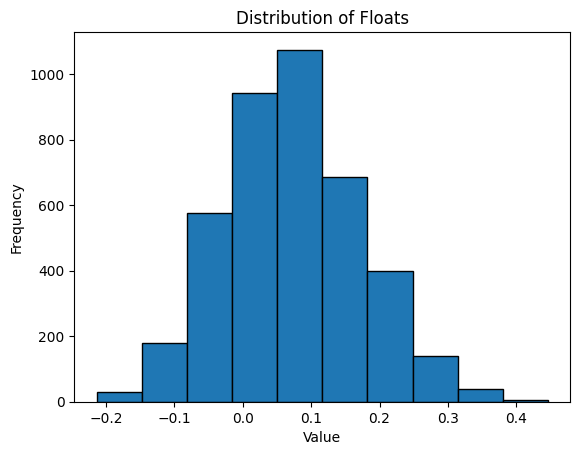

In [46]:
# Generate histogram bins and counts
counts, bins, _ = plt.hist(similarity_score_dist, bins=10, edgecolor='black')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Floats')

# Show the plot
plt.show()

In [47]:
# Calculate the mean
mean_value = np.mean(similarity_score_dist)

# Calculate the median
median_value = np.median(similarity_score_dist)

# Print the results
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")

Mean: 0.07283803169908164
Median: 0.069673091173172


#### Application with word semantics

In [39]:
extracted_keywords = 0
true_positives = 0
true_keywords = 0 
keyword_threshold = 0.80

filenumber = 1751

for abstract, keywords in testing_set.items():
    with open(os.path.join(stopwords_abstracts_folder, abstract), 'r', encoding='utf-8') as file:
      abstract_text = file.read()

    r = Rake(stopwords=stoplists[3], similarity_model=spaCy, keyword_threshold=keyword_threshold)
    r.extract_keywords_from_text(abstract_text)
    ranked_keywords = r.get_ranked_phrases_with_scores()

    # Create a set to store unique keywords
    unique_ranked_keywords = []

    # Filter out duplicates
    for score, keyword in ranked_keywords:
        if keyword not in unique_ranked_keywords:
            unique_ranked_keywords.append(keyword)


    T = math.floor(len(unique_ranked_keywords) * 0.5) # Parameter to limit the number of extracted keywords
    unique_ranked_keywords = unique_ranked_keywords[:T]
    extracted_keywords += T
    assigned_keywords = read_keywords_file(os.path.join(stopwords_keys_folder, keywords))
    true_keywords += len(assigned_keywords)
    true_positives += len(set(unique_ranked_keywords[:]).intersection(assigned_keywords))

    if filenumber == 1761:
        break

    filenumber += 1


# Calculate overall precision, recall, and F1-score
precision = true_positives / extracted_keywords if extracted_keywords > 0 else 0
recall = true_positives / true_keywords if true_keywords > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f'Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}')
print(f'Number of extracted keywords: {extracted_keywords}')
print(f'Number of true keywords: {true_keywords}')
print(f'True positives: {true_positives}\n')



/tmp/ipykernel_5137/339423867.py:296: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_score = self.similarity_model(words[i]).similarity(self.similarity_model(words[j]))


Precision: 0.3489583333333333
Recall: 0.366120218579235
F1-Score: 0.35733333333333334
Number of extracted keywords: 192
Number of true keywords: 183
True positives: 67



#### Application with keyword semantics

In [40]:
def calculate_ranked_keyword_spacy_similarity(keywords):
    keyword_vectors = np.vstack([spaCy(keyword).vector for keyword in keywords])
    return cosine_similarity(keyword_vectors, keyword_vectors)

In [42]:
extracted_keywords = [0,0]
true_positives = 0
true_keywords = 0 
keyword_threshold = 0.85
removed_keywords = 0

filenumber = 1751

for abstract, keywords in testing_set.items():
    with open(os.path.join(stopwords_abstracts_folder, abstract), 'r', encoding='utf-8') as file:
      abstract_text = file.read()

    r = Rake(stopwords=stoplists[3])
    r.extract_keywords_from_text(abstract_text)
    ranked_keywords = r.get_ranked_phrases_with_scores()

    unique_ranked_keywords = []
    seen = set() 

    for item in ranked_keywords:
        if item[1] not in seen:
            seen.add(item[1])
            unique_ranked_keywords.append(item)

    removed_keyword_indices = []
    similarity_matrix = calculate_ranked_keyword_spacy_similarity([item[1] for item in unique_ranked_keywords])

    for i in range(len(similarity_matrix)):
        for j in range(len(similarity_matrix)):
            if i != j:
                if similarity_matrix[i,j] >= keyword_threshold:
                    if unique_ranked_keywords[i][0] > unique_ranked_keywords[j][0]:
                        if j not in removed_keyword_indices:
                            removed_keyword_indices.append(j)
                    elif unique_ranked_keywords[j][0] > unique_ranked_keywords[i][0]:
                        if i not in removed_keyword_indices:
                            removed_keyword_indices.append(i)

    extracted_keywords[0] += len(unique_ranked_keywords) # Number of extracted keywords before i remove the similar extracted keywords with lower scores
    removed_keywords += len(removed_keyword_indices)


    # Remove the similar keywords from the ranked list
    unique_ranked_keywords = [unique_ranked_keywords[i] for i in range(len(unique_ranked_keywords)) if i not in removed_keyword_indices]

    T = math.floor(len(unique_ranked_keywords) * 0.5) # Parameter to limit the number of extracted keywords
    unique_ranked_keywords = unique_ranked_keywords[:T]
    extracted_keywords[1] += T # Number of extracted keywords after i remove the similar extracted keyowrds with lower scores
    assigned_keywords = read_keywords_file(os.path.join(stopwords_keys_folder, keywords))
    true_keywords += len(assigned_keywords)
    true_positives += len(set([item[1] for item in unique_ranked_keywords]).intersection(assigned_keywords))

    if filenumber == 1761:
        break


    filenumber += 1


# Calculate overall precision, recall, and F1-score
precision = true_positives / extracted_keywords[1] if extracted_keywords[1] > 0 else 0
recall = true_positives / true_keywords if true_keywords > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f'Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}')
print(f'Number of extracted keywords: {extracted_keywords[1]}')
print(f'Number of true keywords: {true_keywords}')
print(f'True positives: {true_positives}\n')
print(f'Total number of extracted keywords: {extracted_keywords[0]}')
print(f'Number of removed keywords: {removed_keywords}')
print(f'Ratio of extracted keywords and removed keywords: {removed_keywords/extracted_keywords[0]}')


Precision: 0.35403726708074534
Recall: 0.3114754098360656
F1-Score: 0.33139534883720934
Number of extracted keywords: 161
Number of true keywords: 183
True positives: 57

Total number of extracted keywords: 390
Number of removed keywords: 62
Ratio of extracted keywords and removed keywords: 0.15897435897435896


### RAKE Application III
In this application of RAKE, i utilize a subset of the total number of extracted keywords set by a parameter T. The match between an extracted keyword and a true keyword happens by 

- checking if an extracted keyword from the subset is equal to any of the true keywords (the intersection between the extracted keywords and the true keywords)
- calculating how similar the extracted keywords are to the true keywords using the spaCy model, or Word2Vec

In [44]:
def count_words(keywords):
    return [len(keyword.split()) for keyword in keywords]

In [52]:
extracted_keywords = 0
true_positives = 0
true_keywords = 0 

keyphrase_threshold = 0.8
keyword_threshold = 0.8

distributions = [
   [], # Number of words within each assigned keyword
   [], # Number of words within each assigned keyword that is a mismatch to the extracted keywords
   [], # Number of words within each extracted keyword
]

filenumber = 1751

for abstract, keywords in testing_set.items():
    with open(os.path.join(stopwords_abstracts_folder, abstract), 'r', encoding='utf-8') as file:
      abstract_text = file.read()

    r = Rake(stopwords=stoplists[3])
    r.extract_keywords_from_text(abstract_text)
    ranked_keywords = r.get_ranked_phrases_with_scores()

    # Create a list to store unique keywords
    unique_ranked_keywords = []
    
    # Filter out duplicates
    for score, keyword in ranked_keywords:
        if keyword not in unique_ranked_keywords:
            unique_ranked_keywords.append(keyword)

    
    assigned_keywords = list(read_keywords_file(os.path.join(stopwords_keys_folder, keywords)))
    true_keywords += len(assigned_keywords)
    for keyword_count in count_words(assigned_keywords): distributions[0].append(keyword_count)

    T = math.floor(len(unique_ranked_keywords) * 0.5) # Parameter to limit the number of extracted keywords
    extracted_keywords += T
    unique_ranked_keywords = unique_ranked_keywords[:T]
    for keyword_count in count_words(unique_ranked_keywords): distributions[2].append(keyword_count)

    identical_keywords = list(set(unique_ranked_keywords).intersection(assigned_keywords))
    local_true_positives = 0

    if len(identical_keywords) > 0: # If there are identical keywords
        
        # Remove the identical keywords from both the list of assigned keywords and the list of extracted keywords
        assigned_keywords = [keyword for keyword in assigned_keywords if keyword not in identical_keywords]
        unique_ranked_keywords = [keyword for keyword in unique_ranked_keywords if keyword not in identical_keywords]

        local_true_positives = len(identical_keywords) # Update the local_true_positives variable with the number of identical keywords

        if len(assigned_keywords) == 0 or len(unique_ranked_keywords) == 0: # If by removing the identical keywords from the two lists we end up with zero length 
           true_positives += local_true_positives # Update the total true positives with the local true positives calculated so far
           continue    

    # Calculate the similarity matrix
    similarity_matrix = calculate_keyword_spacy_similarity(assigned_keywords, unique_ranked_keywords)

    # If there exists an extracted keyword with similarity score > the threshold for each assigned keyword, update the local_true_positives
    for i, true_keyword in enumerate(similarity_matrix):
       if max(true_keyword) >= keyphrase_threshold:
          local_true_positives += 1
       else:
          distributions[1].append(len(assigned_keywords[i].split()))
          
    
    true_positives += local_true_positives

    #if filenumber == 1761:
       #break
       
    #filenumber += 1
    
# Calculate overall precision, recall, and F1-score
precision = true_positives / extracted_keywords if extracted_keywords > 0 else 0
recall = true_positives / true_keywords if true_keywords > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f'Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}')
print(f'Number of extracted keywords: {extracted_keywords}')
print(f'Number of true keywords: {true_keywords}')
print(f'True positives: {true_positives}\n')


Precision: 0.5853598624416605
Recall: 0.6973953760608721
F1-Score: 0.6364850427350427
Number of extracted keywords: 4071
Number of true keywords: 3417
True positives: 2383



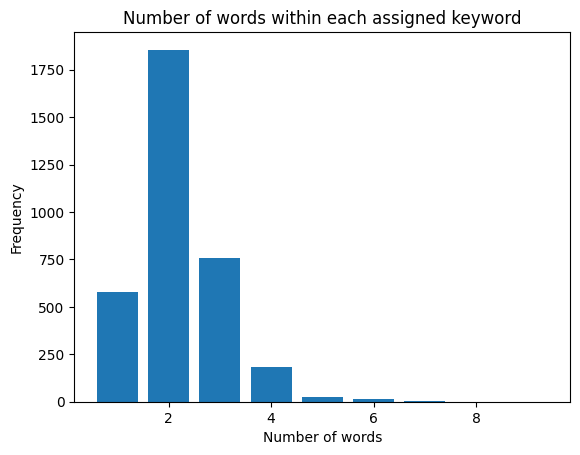

In [48]:
plt.bar(Counter(distributions[0]).keys(), Counter(distributions[0]).values())
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Number of words within each assigned keyword')
plt.show()

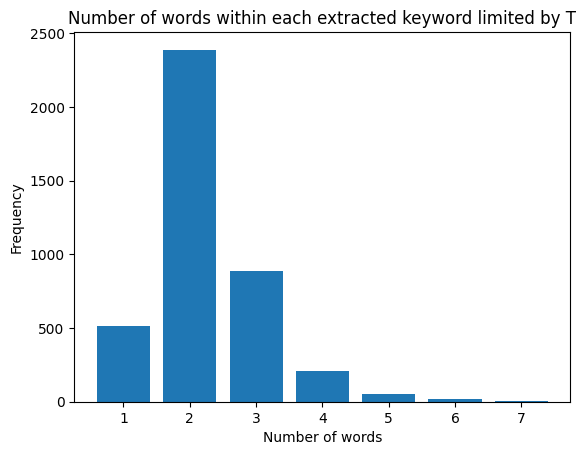

In [47]:
plt.bar(Counter(distributions[2]).keys(), Counter(distributions[2]).values())
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Number of words within each extracted keyword limited by T')
plt.show()

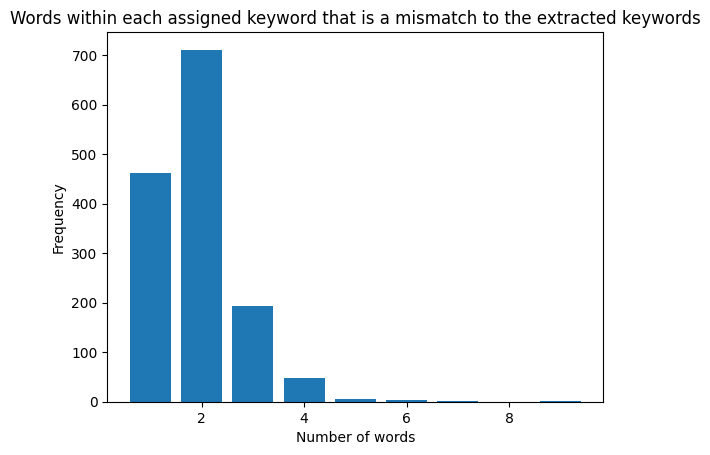

In [51]:
plt.bar(Counter(distributions[1]).keys(), Counter(distributions[1]).values())
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Words within each assigned keyword that is a mismatch to the extracted keywords')
plt.show()

# KeyBERT

In [48]:
from keybert import KeyBERT

In [49]:
keybert = KeyBERT()

## RAKE with KeyBERT

### RAKE with KeyBERT keyword scores as weights

In [49]:
extracted_keywords = 0
true_positives = 0
true_keywords = 0 
RAKE_KeyBERT_keywords = 0
keyphrase_threshold = 0.8

filenumber = 1751

for abstract, keywords in testing_set.items():
    with open(os.path.join(stopwords_abstracts_folder, abstract), 'r', encoding='utf-8') as file:
      abstract_text = file.read()

    # RAKE
    r = Rake(stopwords=stoplists[3])
    r.extract_keywords_from_text(abstract_text)
    ranked_keywords = r.get_ranked_phrases_with_scores()

    assigned_keywords = read_keywords_file(os.path.join(stopwords_keys_folder, keywords))
    true_keywords += len(assigned_keywords)

    # KeyBERT
    keybert_keywords = keybert.extract_keywords(abstract_text, keyphrase_ngram_range=(1, 3))
                                        #use_maxsum=True, nr_candidates=len(unique_ranked_keywords), top_n=len(assigned_keywords))

    # Loop through RAKE keywords
    for rake_score, rake_keyword in ranked_keywords:
        # Check if the RAKE keyword exists in KeyBERT keywords
        for keybert_keyword, keybert_score in keybert_keywords:
            if rake_keyword in keybert_keyword:
                # Multiply the existing RAKE score with KeyBERT score
                rake_score *= keybert_score
                RAKE_KeyBERT_keywords += 1
                break  # Break the inner loop once a match is found


    # Sort the RAKE keywords based on the modified scores
    sorted_rake_keywords = sorted(ranked_keywords, key=lambda x: x[0], reverse=True)

    # Create a set to store unique keywords
    unique_ranked_keywords = []

    # Filter out duplicates
    for score, keyword in ranked_keywords:
        if keyword not in unique_ranked_keywords:
            unique_ranked_keywords.append(keyword)


    T = math.floor(len(unique_ranked_keywords) * 0.5) # Parameter to limit the number of extracted keywords
    unique_ranked_keywords = unique_ranked_keywords[:T]
    extracted_keywords += T

    identical_keywords = list(set(unique_ranked_keywords).intersection(assigned_keywords))
    local_true_positives = 0

    if len(identical_keywords) > 0:
        assigned_keywords = [keyword for keyword in assigned_keywords if keyword not in identical_keywords]
        unique_ranked_keywords = [keyword for keyword in unique_ranked_keywords if keyword not in identical_keywords]
        local_true_positives = len(identical_keywords)

        if len(assigned_keywords) == 0 or len(unique_ranked_keywords) == 0:
           true_positives += local_true_positives
           continue    

    # Calculate similarity matrix
    similarity_matrix = calculate_keyword_spacy_similarity(assigned_keywords, unique_ranked_keywords)

    for true_keyword in similarity_matrix:
       if max(true_keyword) >= keyphrase_threshold:
          local_true_positives += 1
    
    true_positives += local_true_positives
    
    #if filenumber == 1761:
        #break

    
    #filenumber += 1


# Calculate overall precision, recall, and F1-score
precision = true_positives / extracted_keywords if extracted_keywords > 0 else 0
recall = true_positives / true_keywords if true_keywords > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f'Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}')
print(f'Number of extracted keywords: {extracted_keywords}')
print(f'Number of true keywords: {true_keywords}')
print(f'True positives: {true_positives}\n')
print(f'RAKE and KeyBERT identical keywords: {RAKE_KeyBERT_keywords}')

Precision: 0.4890690248096291
Recall: 0.5826748609891718
F1-Score: 0.531784188034188
Number of extracted keywords: 4071
Number of true keywords: 3417
True positives: 1991

RAKE and KeyBERT identical keywords: 1632


### RAKE with KeyBERT unified keywords

In [52]:
extracted_keywords = 0
true_positives = 0
true_keywords = 0 
RAKE_KeyBERT_keywords = 0
keyphrase_threshold = 0.8
similarity_score_dist = []

filenumber = 1751

for abstract, keywords in testing_set.items():
    with open(os.path.join(stopwords_abstracts_folder, abstract), 'r', encoding='utf-8') as file:
      abstract_text = file.read()

    # RAKE
    r = Rake(stopwords=stoplists[3])
    r.extract_keywords_from_text(abstract_text)
    ranked_keywords = list(set(r.get_ranked_phrases_with_scores()))

    # KeyBERT
    keybert_keywords = keybert.extract_keywords(abstract_text, keyphrase_ngram_range=(1, 3))
                                        #use_maxsum=True, nr_candidates=len(unique_ranked_keywords), top_n=len(assigned_keywords))

    # Normalize RAKE scores
    max_rake_score = max(ranked_keywords, key=lambda x: x[0])[0]
    normalized_rake_ranked_keywords = [(score / max_rake_score, keyword) for score, keyword in ranked_keywords]

    # Combine RAKE and KeyBERT keywords
    combined_keywords = Counter()

    for score, keyword in normalized_rake_ranked_keywords:
        combined_keywords[keyword] += score

    for keyword, score in keybert_keywords:
        combined_keywords[keyword] += score

    # Create a set to store unique keywords
    ranked_keywords_without_scores = []

    for keyword in combined_keywords.keys():
        if keyword not in ranked_keywords_without_scores:
            ranked_keywords_without_scores.append(keyword)

    assigned_keywords = read_keywords_file(os.path.join(stopwords_keys_folder, keywords))
    true_keywords += len(assigned_keywords)

    T = math.floor(len(ranked_keywords_without_scores) * 0.5) # Parameter to limit the number of extracted keywords
    ranked_keywords_without_scores = ranked_keywords_without_scores[:T]
    extracted_keywords += T

    """
    identical_keywords = list(set(ranked_keywords_without_scores).intersection(assigned_keywords))
    local_true_positives = 0

    if len(identical_keywords) > 0:
        assigned_keywords = [keyword for keyword in assigned_keywords if keyword not in identical_keywords]
        ranked_keywords_without_scores = [keyword for keyword in ranked_keywords_without_scores if keyword not in identical_keywords]
        local_true_positives = len(identical_keywords)

        if len(assigned_keywords) == 0 or len(ranked_keywords_without_scores) == 0:
           true_positives += local_true_positives
           continue    

    # Calculate similarity matrix
    similarity_matrix = calculate_keyword_spacy_similarity(assigned_keywords, ranked_keywords_without_scores)

    for true_keyword in similarity_matrix:
       if max(true_keyword) >= keyphrase_threshold:
          local_true_positives += 1
    
    true_positives += local_true_positives
    """
    true_positives += len(set(ranked_keywords_without_scores).intersection(assigned_keywords))

    extracted_keywords_abstract_similarity = calculate_similarity_with_bert(ranked_keywords_without_scores, abstract, bert_model)
    for score in extracted_keywords_abstract_similarity[0]:
        similarity_score_dist.append(score)
        
    #if filenumber == 1761:
        #break

    #filenumber += 1

# Calculate overall precision, recall, and F1-score
precision = true_positives / extracted_keywords if extracted_keywords > 0 else 0
recall = true_positives / true_keywords if true_keywords > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f'Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}')
print(f'Number of extracted keywords: {extracted_keywords}')
print(f'Number of true keywords: {true_keywords}')
print(f'True positives: {true_positives}\n')
print(f'RAKE and KeyBERT identical keywords: {RAKE_KeyBERT_keywords}')

Precision: 0.18728222996515678
Recall: 0.2516827626573017
F1-Score: 0.21475839680359596
Number of extracted keywords: 4592
Number of true keywords: 3417
True positives: 860

RAKE and KeyBERT identical keywords: 0


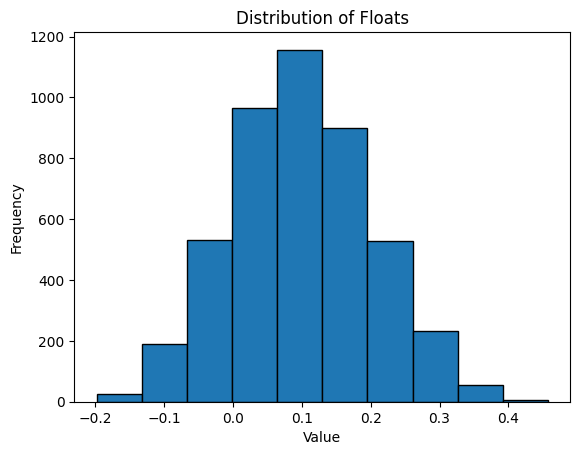

In [53]:
# Generate histogram bins and counts
counts, bins, _ = plt.hist(similarity_score_dist, bins=10, edgecolor='black')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Floats')

# Show the plot
plt.show()

In [54]:
# Calculate the mean
mean_value = np.mean(similarity_score_dist)

# Calculate the median
median_value = np.median(similarity_score_dist)

# Print the results
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")

Mean: 0.09976130355855706
Median: 0.09668351337313652


### RAKE with KeyBERT candidate keywords

In [58]:
extracted_keywords = 0
true_positives = 0
true_keywords = 0 
similarity_score_dist = []

keyphrase_threshold = 0.8

filenumber = 1751

for abstract, keywords in testing_set.items():
    with open(os.path.join(stopwords_abstracts_folder, abstract), 'r', encoding='utf-8') as file:
      abstract_text = file.read()

    assigned_keywords = list(read_keywords_file(os.path.join(stopwords_keys_folder, keywords)))
    true_keywords += len(assigned_keywords)

    try:
        keybert_keywords = keybert.extract_keywords(abstract_text, keyphrase_ngram_range=(1, 3), top_n=len(assigned_keywords))
    except:
        keybert_keywords = keybert.extract_keywords(abstract_text, keyphrase_ngram_range=(1, 3))


    r = Rake(stopwords=stoplists[3], keyBERT_keywords=keybert_keywords)
    r.extract_keywords_from_text(abstract_text)
    ranked_keywords = r.get_ranked_phrases_with_scores()

    # Create a list to store unique keywords
    unique_ranked_keywords = []
    
    # Filter out duplicates
    for score, keyword in ranked_keywords:
        if keyword not in unique_ranked_keywords:
            unique_ranked_keywords.append(keyword)


    T = math.floor(len(unique_ranked_keywords) * 0.5) # Parameter to limit the number of extracted keywords
    extracted_keywords += T
    unique_ranked_keywords = unique_ranked_keywords[:T]

    """
    identical_keywords = list(set(unique_ranked_keywords).intersection(assigned_keywords))
    local_true_positives = 0

    if len(identical_keywords) > 0:
        assigned_keywords = [keyword for keyword in assigned_keywords if keyword not in identical_keywords]
        unique_ranked_keywords = [keyword for keyword in unique_ranked_keywords if keyword not in identical_keywords]
        local_true_positives = len(identical_keywords)

        if len(assigned_keywords) == 0 or len(unique_ranked_keywords) == 0:
           true_positives += local_true_positives
           continue    

    # Calculate similarity matrix
    similarity_matrix = calculate_keyword_spacy_similarity(assigned_keywords, unique_ranked_keywords)

    for true_keyword in similarity_matrix:
       if max(true_keyword) >= keyphrase_threshold:
          local_true_positives += 1
       
    true_positives += local_true_positives
    """
    true_positives += len(set(unique_ranked_keywords).intersection(assigned_keywords))

    extracted_keywords_abstract_similarity = calculate_similarity_with_bert(unique_ranked_keywords, abstract, bert_model)
    for score in extracted_keywords_abstract_similarity[0]:
        similarity_score_dist.append(score)

    #if filenumber == 1761:
       #break
       
    #filenumber += 1
    
# Calculate overall precision, recall, and F1-score
precision = true_positives / extracted_keywords if extracted_keywords > 0 else 0
recall = true_positives / true_keywords if true_keywords > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f'Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}')
print(f'Number of extracted keywords: {extracted_keywords}')
print(f'Number of true keywords: {true_keywords}')
print(f'True positives: {true_positives}\n')


Precision: 0.1647892441860465
Recall: 0.26543751829089846
F1-Score: 0.2033404326869185
Number of extracted keywords: 5504
Number of true keywords: 3417
True positives: 907



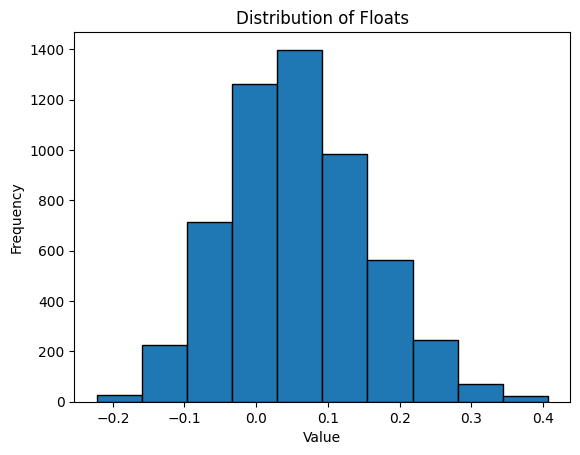

In [59]:
# Generate histogram bins and counts
counts, bins, _ = plt.hist(similarity_score_dist, bins=10, edgecolor='black')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Floats')

# Show the plot
plt.show()

In [60]:
# Calculate the mean
mean_value = np.mean(similarity_score_dist)

# Calculate the median
median_value = np.median(similarity_score_dist)

# Print the results
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")

Mean: 0.05798967350042509
Median: 0.053778788074851036


## KeyBERT without RAKE

In [ ]:
extracted_keywords = 0
true_positives = 0
true_keywords = 0 
keyphrase_threshold = 0.8

filenumber = 1751

for abstract, keywords in testing_set.items():
    with open(os.path.join(stopwords_abstracts_folder, abstract), 'r', encoding='utf-8') as file:
      abstract_text = file.read()

    assigned_keywords = read_keywords_file(os.path.join(stopwords_keys_folder, keywords))
    true_keywords += len(assigned_keywords)

    # RAKE
    r = Rake(stopwords=stoplists[3])
    r.extract_keywords_from_text(abstract_text)
    ranked_keywords = list(set(r.get_ranked_phrases_with_scores()))

    # KeyBERT
    try:
        keybert_keywords = keybert.extract_keywords(abstract_text, keyphrase_ngram_range=(1, 3), use_maxsum=True, nr_candidates=len(ranked_keywords), top_n=len(assigned_keywords))
    except:
       keybert_keywords = keybert.extract_keywords(abstract_text, keyphrase_ngram_range=(1, 3), use_maxsum=True)

    keybert_keywords_list = [item[0] for item in keybert_keywords]

    extracted_keywords += len(keybert_keywords)

    identical_keywords = list(set(keybert_keywords_list).intersection(assigned_keywords))
    local_true_positives = 0

    if len(identical_keywords) > 0:
        assigned_keywords = [keyword for keyword in assigned_keywords if keyword not in identical_keywords]
        keybert_keywords_list = [keyword for keyword in keybert_keywords_list if keyword not in identical_keywords]
        local_true_positives = len(identical_keywords)

        if len(assigned_keywords) == 0 or len(keybert_keywords_list) == 0:
           true_positives += local_true_positives
           continue    

    # Calculate similarity matrix
    similarity_matrix = calculate_keyword_spacy_similarity(assigned_keywords, keybert_keywords_list)

    for true_keyword in similarity_matrix:
       if max(true_keyword) >= keyphrase_threshold:
          local_true_positives += 1
    
    true_positives += local_true_positives
    
    if filenumber == 1761:
        break
    print(filenumber)

    
    filenumber += 1


# Calculate overall precision, recall, and F1-score
precision = true_positives / extracted_keywords if extracted_keywords > 0 else 0
recall = true_positives / true_keywords if true_keywords > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f'Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}')
print(f'Number of extracted keywords: {extracted_keywords}')
print(f'Number of true keywords: {true_keywords}')
print(f'True positives: {true_positives}\n')
